In [887]:
import yfinance as yf
import mplfinance as mpf
from binance.client import Client
import os
import ta
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import polars as pl
import datetime

data = yf.download(tickers='BTC-USD', period='max', interval='1d')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-06-30,30441.353516,31256.863281,29600.275391,30477.251953,30477.251953,26387306197
2023-07-01,30471.847656,30641.289062,30328.865234,30590.078125,30590.078125,9086606733
2023-07-02,30587.269531,30766.140625,30264.019531,30620.769531,30620.769531,10533418042


SLOPE, INTERCEPTS and difference STEPS

In [858]:
# 2 argument l avna
def direction_and_steps(datapoints):
    if datapoints.index[0] > datapoints.index[1]:
        startIndex = datapoints.index[0]
        endIndex = datapoints.index[1]
    else:
        startIndex = datapoints.index[1]
        endIndex = datapoints.index[0]
    a = datapoints.head(1)
    b = datapoints.tail(1)
    a_value = a[0]
    b_value = b[0]
    ascending = False

# ========================
    if b.index < a.index:
        oldIndex = b.index
        newIndex = a.index
        if b_value > a_value:
            max = b_value
            min = a_value
            ascending = False
            # print("descending")
        else:
            max = a_value
            min = b_value
            ascending = True
            # print('ascending')
    elif b.index > a.index:
        oldIndex = a.index
        newIndex = b.index
        if b_value > a_value:
            max = b_value
            min = a_value
            ascending = True
            # print('ascending')
        else:
            max = a_value
            min = b_value
            ascending = False
            # print('descending')

    top_diff = max - min
    # print('difference = ', top_diff)
    filtered = df[(df.index <= startIndex) & (df.index >= endIndex)]
    numrange = len(filtered)
    # print('range =', numrange)
    diff_step = top_diff/numrange
    return diff_step, ascending
# === test ===
resistance_points = resistances.sort_values(ascending=False).tail(2)

diff_step, lineAscending = direction_and_steps(resistance_points)
# print('diff = ', diff_step)
lineAscending

RETURN min & max from 2 POINTS

In [700]:
def min_max(datapoints):
    a = datapoints.head(1)
    b = datapoints.tail(1)
    a_value = a[0]
    b_value = b[0]
    if b_value > a_value:
        max = b_value
        min = a_value
        # print("max= ", max, "min= ", min)
    else:
        max = a_value
        min = b_value
        # print("max= ", max, "min= ", min)
    return min, max

In [701]:
min_max(resistance_points)

max=  241.97799682617188 min=  237.90899658203125


(237.90899658203125, 241.97799682617188)

EXTREMUM hoorondiin data range easify

In [702]:
def start_end_ragne(datapoints):
    if datapoints.index[1] > datapoints.index[0]:
        startIndex = datapoints.index[0]
        endIndex = datapoints.index[1]
    else:
        startIndex = datapoints.index[1]
        endIndex = datapoints.index[0]
    return startIndex, endIndex

start, end = start_end_ragne(resistance_points)
# print("started= ", start)
# print('ended =', end)

started=  2015-04-22 00:00:00
ended = 2015-05-24 00:00:00


LEVELS

In [884]:
resistances

Date
2015-04-22    237.908997
2015-05-03    243.240005
2015-05-09    247.804001
2015-05-24    241.977997
2015-06-17    256.852997
2015-06-30    267.867004
Name: High, dtype: float64

In [885]:
resistance_points

Date
2015-05-24    241.977997
2015-04-22    237.908997
Name: High, dtype: float64

RESISTANCE until NOW

In [ ]:
def resistance(df):
    # print("Calculating resistance")
    resistances = df[df.High == df.High.rolling(10, center=True).max()].High
    resistance_points = resistances.sort_values(ascending=True).tail(2)

    # resistance coefficients
    diff_step, lineAscending = direction_and_steps(resistance_points)
    start, end = start_end_ragne(resistance_points)
    # today = df[(df.index > resistance_points.index[0])]
    today = df[(df.index > start)]

    x_values = []
    y_values = []

    min, max = min_max(resistance_points)
    y = resistance_points[0]
    # today['resistance'] = np.nan

    if lineAscending == True:
        y = min
        for i in today.index:
            y = y + diff_step
            y_values.append(y)
            x_values.append(i)
            # today.loc[today.index==i, 'resistance'] = y
            df.loc[df.index==i, 'resistance'] = y
    elif lineAscending == False:
        y = max
        for i in today.index:
            y = y - diff_step
            y_values.append(y)
            x_values.append(i)
            # today.loc[today.index==i, 'resistance'] = y
            df.loc[df.index==i, 'resistance'] = y

    # print("Resistance ascending", lineAscending)
    # print("Diff points", diff_step)
    # # y_values
# ==== run test ====
resistance(df)

SUPPORT

In [853]:
def support(df):
    supports = df[df.Low == df.Low.rolling(10, center=True).min()].Low
    support_points = supports.sort_values(ascending=True).head(2)
    
    # start_point
    start, end = start_end_ragne(support_points)
    support_today = df[(df.index > start)]
    # support coefficients
    diff_step, lineAscending = direction_and_steps(support_points)

    numrange = len(support_today)
    x_values = []
    y_values = []

    min, max = min_max(support_points)
    y = support_points[0]

    if lineAscending == True:
        y = min
        for i in support_today.index:
            y = y + diff_step
            y_values.append(y)
            x_values.append(i)
            df.loc[df.index==i, 'support'] = y
    elif lineAscending == False:
        y = max
        for i in support_today.index:
            y = y - diff_step
            y_values.append(y)
            x_values.append(i)
            df.loc[df.index==i, 'support'] = y

# run test
# support(df)

MACD & RSI & STOCHASTIC OSCILLATOR

In [868]:
data['macd'] = np.nan
data['rsi'] = np.nan
data['%D'] = np.nan
data['%K'] = np.nan
df = data[0:100]

def applytechnicals(df):
    # window for 14 days and smooth window for 3days
    df['%K'] = ta.momentum.stoch(df.High, df.Low, df.Close, window=14, smooth_window=3)
    df['%D'] = df['%K'].rolling(3).mean()
    df['rsi'] = ta.momentum.rsi(df.Close, window=14)
    df['macd'] = ta.trend.macd_diff(df.Close)
    df.dropna(inplace=True)
    return df

BUY SIGNALS

In [898]:
def decide():
    # df['Buy'] = np.where( (df['%K'].between(20,80)) & (df['%D'].between(20,80)) & (df.rsi > 50) & (df.macd > 0), 1, -1)
    # df['Buy'] = np.where( (df.rsi > 50) & (df.macd > 0), df["Close"], np.nan)
    df['Buy'] = np.where( (df['%K'].between(2,20)) & (df['%D'].between(2,20)) & (df['%K'] < df['%D'] ) & (df.rsi < 55) , df["Close"], np.nan)
    # df['Buy'] = np.where( (df['%K'] < df['%D'] ) & (df.rsi < 55) , df["Close"], np.nan)

In [ ]:
df

PLOTTING

In [ ]:
# ===== RUN FUNCTION ======
df = data[0:100]
df['resistance'] = np.nan
df['support'] = np.nan
# ===== Calculate Channel ====
resistance(df)
support(df)
applytechnicals(df)

/tmp/ipykernel_3191/1470351987.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



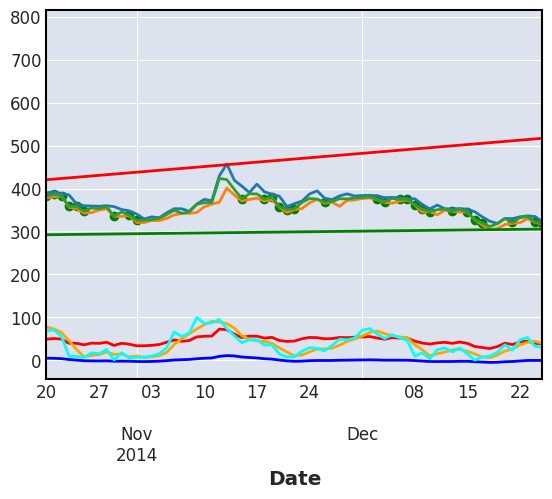

In [897]:
decide()
# plot_df(df)

# ===== PLOT =====
clean_levels = levels[abs(levels.diff() > 0)]
df.High.plot()
df.Low.plot()
df.Close.plot()

plt.hlines(clean_levels, xmin=clean_levels.index, xmax=clean_levels.index[-1], colors='red')
plt.scatter(resistances.index, resistances, color='b')
# plt.scatter(support_points.index, support_points, color="g")
plt.plot(df.index, df['resistance'], color="r")
plt.plot(df.index, df['support'], color="g")
plt.plot(df.index, df['macd'], color="blue")
plt.plot(df.index, df["rsi"], color='r')
plt.plot(df.index, df["%D"], color="orange")
plt.plot(df.index, df["%K"], color="cyan")
plt.scatter(df.index, df['Buy'], color="g")

PLOTTING and SAVE

In [ ]:
# ====== PLOTTING and SAVING =========
# MATPLOTLIB
# clean_levels = levels[abs(levels.diff() > 0)]
def plot_df(df):
    df.High.plot()
    df.Low.plot()
    df.Close.plot()
    # plt.hlines(clean_levels, xmin=clean_levels.index, xmax=clean_levels.index[-1], colors='red')
    plt.scatter(resistances.index, resistances, color='b')
    # plt.scatter(support_points.index, support_points, color="g")
    plt.plot(df.index, df['resistance'], color="r")
    plt.plot(df.index, df['support'], color="g")
    # plt.plot(today.index, y_values, color="y")
    now = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
    startDate = df.index[0].strftime("%Y-%m-%d")
    endDate = df.index[-1].strftime("%Y-%m-%d")
    save_name = startDate + '_to_' + endDate
    save_name
    plt.savefig('charts/1h/' +save_name+'_signals.jpg')

Test with Iteration

In [ ]:
dataStart = 0
for i in range(100, len(data),100):
    print('dataStart= ', dataStart, ' i= ', i)
    # ==== setting range of df ====
    df = data[dataStart:i]
    df['resistance'] = np.nan
    df['support'] = np.nan
    # plt.plot(df.index, df.Close)
    # plt.show()
    # ===== Calculate Channel ====
    resistance(df)
    support(df)
    plot_df(df)
    dataStart = i


TEST by ONE

/tmp/ipykernel_3191/1922186432.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/1922186432.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/

max=  457.0929870605469 min=  411.697998046875
Resistance ascending True
Diff points 1.464354484311996
max=  304.23199462890625 min=  289.2959899902344


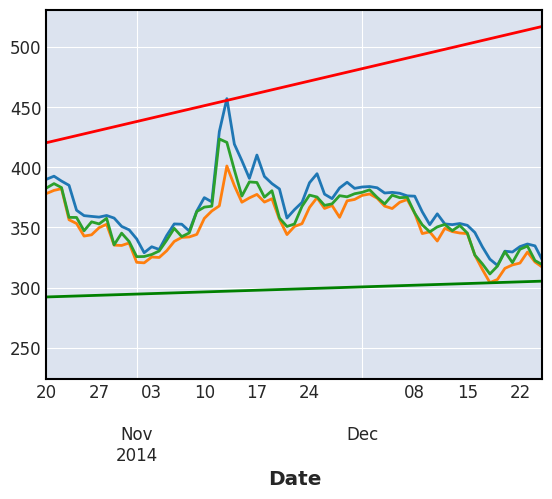

In [891]:
df = data[0:100]
df['resistance'] = np.nan
df['support'] = np.nan
# plt.plot(df.index, df.Close)
# plt.show()
# ===== Calculate Channel ====
resistance(df)
support(df)
applytechnicals(df)
decide()
plot_df(df)

УРТ ХУГАЦААГААР ХАРАХ ХЭСЭГ

In [857]:
# with indicator
# df = data
# df['resistance'] = np.nan
# df['support'] = np.nan
# # plt.plot(df.index, df.Close)
# # plt.show()
# # ===== Calculate Channel ====
resistance(df)
support(df)
decide()
# ===== PLOTLY =====
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=df.index,
                                    open=df['Open'],
                                    high=df['High'],
                                    low=df['Low'],
                                    close=df['Close'],
                                    increasing_line_color='green',
                                    decreasing_line_color='red'),
                                    go.Scatter(x=df.index, y=df['support'], line=dict(color="green", width=3), name="SUPPORT"),
                                    go.Scatter(x=df.index, y=df['resistance'], line=dict(color='red', width=3), name="RESISTANCE"),
                                    go.Scatter(x=df.index, y=df['Buy'], mode="markers", marker=dict(size=5, color="Orange"), name="Buy")])

fig.update(layout_xaxis_rangeslider_visible=True)
fig.update_layout(paper_bgcolor="black", plot_bgcolor="black", margin_l=0, margin_b=0, margin_r=0, margin_t=0)
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.show()

ascending
difference =  45.394989013671875
range = 31
max=  457.0929870605469 min=  411.697998046875
ascending
difference =  14.936004638671875
range = 75
max=  304.23199462890625 min=  289.2959899902344


/tmp/ipykernel_3191/738999639.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



POLARS
update row